In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from qiskit import*
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.mappers import JordanWignerMapper, BravyiKitaevMapper
import os, qiskit_aer, pickle, itertools
#print(qiskit_aer.__version__)

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_algorithms import TimeEvolutionProblem
# Noisy simulation requires this estimator.
from qiskit_aer.primitives import EstimatorV2 as Estimator
# Noisless simulation requires this estimator.
# from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

"""
The following imports the custom trotter class that includes ancilla qubits for Lindblad operators. 
It is a modified version of the original trotter.py file from qiskit_algorithms located at:
https://github.com/qiskit-community/qiskit-algorithms/blob/main/qiskit_algorithms/time_evolvers/trotterization/trotter_qrte.py
We modified the file to include ancilla qubits for the Lindblad operators and renamed it as trotter_for_open_quantum_systems.py
"""
import trotter_for_open_quantum_systems as trotter

large = 20
med = 15
small = 15
params = {"axes.titlesize": med, "axes.titlepad": med,"legend.fontsize": med, "axes.labelsize": large,"axes.titlesize": med, "xtick.labelsize": large, "ytick.labelsize": large, "figure.titlesize": med}
# plt.rcParams["font.family"] = "Helvetica"
# plt.rcParams["font.serif"] = ["Helvetica Neue"]
#plt.rcParams['text.usetex'] = True  # Use LaTeX in the Plots.
plt.rcParams.update(params)

# Loading the Hamiltonian then mapping to qubits

In [4]:
with open("solvated_active_second_q.pickle", "rb") as f:
    fermionic_hamiltonian = pickle.load(f)

# Converting the fermionic Hamiltonian to a qubit Hamiltonian.
jw_mapper = JordanWignerMapper()
qubit_hamiltonian_jw = jw_mapper.map(fermionic_hamiltonian)

L = len(qubit_hamiltonian_jw.paulis.to_labels()[0]) # Number of qubits.

print("Number of terms in the qubit Hamiltonian after JW = ", len(qubit_hamiltonian_jw))

Number of terms in the qubit Hamiltonian after JW =  53


In [5]:
# We need to truncate the qubit Hamiltonian to a few terms to run it on a quantum computer.
cutoff_threshold = 1.e-10 # in Hartree units.
qubit_hamiltonian_truncated = qubit_hamiltonian_jw.chop(cutoff_threshold).simplify()
# Removing the constant term.
#qubit_hamiltonian_truncated = SparsePauliOp(qubit_hamiltonian_truncated.paulis.to_labels()[1:], qubit_hamiltonian_truncated.coeffs[1:])
print("Number of terms in the truncated qubit Hamiltonian = ", len(qubit_hamiltonian_truncated))

Number of terms in the truncated qubit Hamiltonian =  53


# Determining the LUMO from the Hamiltonian

In [6]:
"""
In this section we will determine the qubit corresponding to the LUMO of the effective Hamiltonian.
"""

def lowest_half_filled_states(Hamiltonian):
     """
     This function returns the lowest energy half-filled states of the fermionic_hamiltonian_matrix. 
     """
     # Generate all possible half-filled states.
     zeros = [0] * (L//2)
     ones = [1] * (L//2)
     binary_list = zeros + ones
     unique_permutations = set(itertools.permutations(binary_list))
     half_filled_states_lst = ["".join(map(str, perm)) for perm in unique_permutations]

     energy_half_filled_states = []
     # Calculate the energy of each half-filled state.
     for half_filled_state in half_filled_states_lst:
          #half_filled_state = half_filled_state[::-1]
          energy_half_filled_states.append((half_filled_state, np.real(Statevector.from_label(half_filled_state).expectation_value(Hamiltonian))))
     sorted_energy_half_filled_states = sorted(energy_half_filled_states, key = lambda x: x[1])
     return sorted_energy_half_filled_states  

In [7]:
number_of_lowest_half_filled_states_to_print = 5
print(f"First few lowest half-filled states of the Hamiltonian are: {lowest_half_filled_states(qubit_hamiltonian_truncated)[:number_of_lowest_half_filled_states_to_print]}")

First few lowest half-filled states of the Hamiltonian are: [('00001111', -91.77986655123816), ('10000111', -68.94354151465531), ('00010111', -68.94354151465531), ('01000111', -68.94354151465531), ('00100111', -68.94354151465531)]


In [24]:
gs = lowest_half_filled_states(qubit_hamiltonian_truncated)[0]
es = lowest_half_filled_states(qubit_hamiltonian_truncated)[1]

In [9]:
gs

('00001111', -91.77986655123816)

In [10]:
es

('10000111', -68.94354151465531)

In [11]:
gs_reversed = gs[0][::-1]
es_reversed = es[0][::-1]
print(f"Ground state is {gs_reversed}")
print(f"First excited state is {es_reversed}")

for idx in range(L):
     if gs_reversed[idx] != es_reversed[idx]:
          print(f"The LUMO is at qubit index {idx}")
          break

Ground state is 11110000
First excited state is 11100001
The LUMO is at qubit index 3


# Noisy simulator

In [12]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
 
# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

# T1 and T2 values for qubits 0-L
T1s = np.random.normal(
    200e3, 10e3, L + 1
)  # Sampled from normal distribution mean 50 microsec
T2s = np.random.normal(
    250e3, 10e3, L + 1
)  # Sampled from normal distribution mean 50 microsec
 
# Truncate random T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(L + 1)])
 
# Instruction times (in nanoseconds)
time_u1 = 0  # virtual gate
time_u2 = 50  # (single X90 pulse)
time_u3 = 100  # (two X90 pulses)
time_cx = 300
time_reset = 1000  # 1 microsecond
time_measure = 1000  # 1 microsecond
 
# QuantumError objects
errors_reset = [
    thermal_relaxation_error(t1, t2, time_reset) for t1, t2 in zip(T1s, T2s)
]
errors_measure = [
    thermal_relaxation_error(t1, t2, time_measure) for t1, t2 in zip(T1s, T2s)
]
errors_u1 = [
    thermal_relaxation_error(t1, t2, time_u1) for t1, t2 in zip(T1s, T2s)
]
errors_u2 = [
    thermal_relaxation_error(t1, t2, time_u2) for t1, t2 in zip(T1s, T2s)
]
errors_u3 = [
    thermal_relaxation_error(t1, t2, time_u3) for t1, t2 in zip(T1s, T2s)
]
errors_cx = [
    [
        thermal_relaxation_error(t1a, t2a, time_cx).expand(
            thermal_relaxation_error(t1b, t2b, time_cx)
        )
        for t1a, t2a in zip(T1s, T2s)
    ]
    for t1b, t2b in zip(T1s, T2s)
]
 
# Add errors to noise model
noise_thermal = NoiseModel()
for j in range(L + 1):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
    noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
    noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
    for k in range(L + 1):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])
 
noisy_estimator = Estimator(options=dict(backend_options=dict(noise_model=noise_thermal)))

print(noise_thermal)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u2', 'u3']
  Instructions with noise: ['u3', 'cx', 'measure', 'reset', 'u2']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8]
  Specific qubit errors: [('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset', (4,)), ('reset', (5,)), ('reset', (6,)), ('reset', (7,)), ('reset', (8,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,)), ('measure', (5,)), ('measure', (6,)), ('measure', (7,)), ('measure', (8,)), ('u2', (0,)), ('u2', (1,)), ('u2', (2,)), ('u2', (3,)), ('u2', (4,)), ('u2', (5,)), ('u2', (6,)), ('u2', (7,)), ('u2', (8,)), ('u3', (0,)), ('u3', (1,)), ('u3', (2,)), ('u3', (3,)), ('u3', (4,)), ('u3', (5,)), ('u3', (6,)), ('u3', (7,)), ('u3', (8,)), ('cx', (0, 0)), ('cx', (0, 1)), ('cx', (0, 2)), ('cx', (0, 3)), ('cx', (0, 4)), ('cx', (0, 5)), ('cx', (0, 6)), ('cx', (0, 7)), ('cx', (0, 8)), ('cx', (1, 0)), ('cx', (1, 1)), ('cx', (1, 2)), ('cx', (1, 3)), ('cx', (1, 

# Number operator $\hat{N} = (I - Z_{j})/2$

In [13]:
n = L + 1  # total qubits
# Qiskit: rightmost char is qubit 0
z_terms = ["I"*(n-1-j) + "Z" + "I"*j for j in range(n)]
op = SparsePauliOp(z_terms, -0.5*np.ones(n))
op += SparsePauliOp(["I"*n], [0.5*n])  # (n/2) * I
number_operator = op.simplify()

# Estimator to calculation expectation values of Pauli strings

In [21]:
""" 
We mostly used Sampler in our research since it can be directly compared to the QPU data.
"""
def current_expectation_value_estimator(initial_state_of_the_system,
                              hamiltonian_of_molecule,
                              LUMO_qubit_index,
                              gamma_in,
                              gamma_out,
                              dt,
                              number_of_data_points):

     initial_state = Statevector.from_label(initial_state_of_the_system)

     circuit_lst = []
     statevector_lst = []
     expectation_values_mean_lst = []
     expectation_values_std_lst = []
     
     new_pauli_labels = [pauli + "I" for pauli in hamiltonian_of_molecule.paulis.to_labels()]

     # Noisy simulator.
     sim_thermal = AerSimulator(noise_model=noise_thermal)

     # estimator = Estimator()

     for ii in range(1, number_of_data_points):
          
          if gamma_in * dt >= 1.0 or gamma_out * dt >= 1.0:
               print("Either gamma_in, gamma_out or dt is too large. Make gamma_in * dt and gamma_out * dt < 1.")
               print("This is necessary for the Trotter approximation to be valid.")
               break

          t_final = np.around(ii*dt,2)
          print("Time = ", t_final)
     
          # This section sets up the time evolution problem and the trotter circuit using the custom trotter class.
          problem = TimeEvolutionProblem(hamiltonian_of_molecule, initial_state = initial_state, time = t_final)

          trotterop = trotter.TrotterQRTE(num_timesteps = ii, LUMO_qubit_index = LUMO_qubit_index, gamma_out = gamma_out, gamma_in = gamma_in, estimator = noisy_estimator)

          result = trotterop.evolve(problem)
          trotter_circuit = result.evolved_state.decompose()
          circuit_lst.append(trotter_circuit)
          statevector_lst.append(Statevector(result.evolved_state))

          # Transpile circuit for noisy basis gates
          # passmanager = generate_preset_pass_manager(
          # optimization_level=3, backend=sim_thermal)
          passmanager = generate_preset_pass_manager(3, AerSimulator()) # Noisy simulator.
          isa_psi = passmanager.run(trotter_circuit)
          
          print("Final depth = ", isa_psi.depth())  
          isa_observables = number_operator.apply_layout(isa_psi.layout)

          job = noisy_estimator.run([(isa_psi, isa_observables)])
          pub_result = job.result()[0]
          expectation_values_mean_lst.append(pub_result.data.evs)
          expectation_values_std_lst.append(pub_result.data.stds)
          
     return expectation_values_mean_lst, expectation_values_std_lst, statevector_lst, circuit_lst

# Expectation value of number operator

In [22]:
gamma_in = 2.0
gamma_out = 2.0
dt = 0.1
LUMO_index = 3
number_of_data_points = 20
gate_folding_number = 0
initial_state = "00001111"
current_mean, current_std, state_lst, circuit_lst = current_expectation_value_estimator(initial_state, qubit_hamiltonian_truncated, LUMO_index, gamma_in, gamma_out, dt, number_of_data_points)

Time =  0.1
Final depth =  690
Time =  0.2
Final depth =  902
Time =  0.3
Final depth =  1114
Time =  0.4
Final depth =  1326
Time =  0.5
Final depth =  1538
Time =  0.6
Final depth =  1750
Time =  0.7
Final depth =  1962
Time =  0.8
Final depth =  2174
Time =  0.9
Final depth =  2386
Time =  1.0
Final depth =  2598
Time =  1.1
Final depth =  2810
Time =  1.2
Final depth =  3022
Time =  1.3
Final depth =  3234
Time =  1.4
Final depth =  3446
Time =  1.5
Final depth =  3658
Time =  1.6
Final depth =  3870
Time =  1.7
Final depth =  4082
Time =  1.8
Final depth =  4294
Time =  1.9
Final depth =  4506


# Number of charges as a function of time

Steady state energy current: 0.034595131605774085


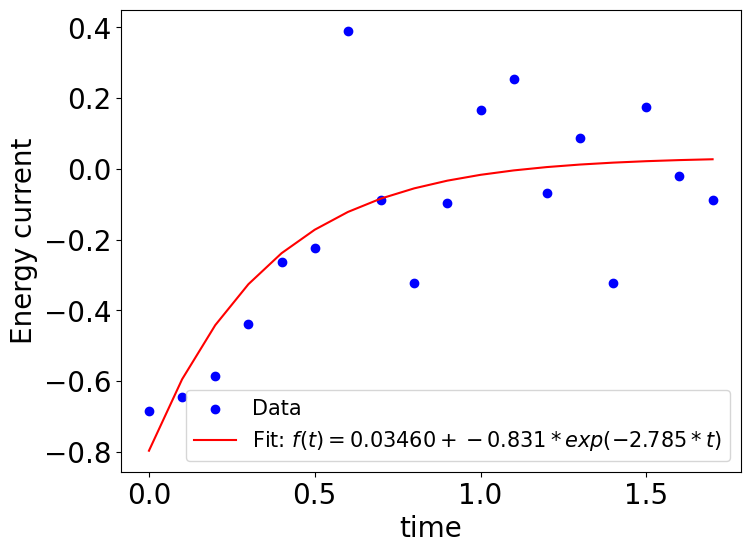

In [20]:
# Define the model function
def model(t, a, b, c):
    return a + b * np.exp(-c * t)

current = np.diff(current_mean)/dt
time_lst = np.arange(0, dt * number_of_data_points, dt)

x = time_lst[:number_of_data_points-2]
y = current

initial_guess = [0.35, -0.4, 1.e-7]
# Fit the data to the model
popt, pcov = curve_fit(model, x, y, p0=initial_guess, maxfev=1000)

# popt contains the optimized parameters a, b, and c
a_fit, b_fit, c_fit = popt

# Generate fitted values using the optimized parameters
y_fit = model(x, *popt)
print("Steady state energy current:", a_fit)

fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(x, y, label='Data', color='blue')
plt.plot(x, y_fit, label=f'Fit: $f(t) = {a_fit:.5f} + {b_fit:.3f}*exp(-{c_fit:.3f}*t)$', color='red')
plt.xlabel('time')
plt.ylabel('Energy current')
plt.legend()
# plt.savefig("B3LYP_def2tzvp.png", dpi = 600, bbox_inches = 'tight')
plt.show()